In [2]:
# connect to the google drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# generate the file path to access the google files.
import os
# the base Google Drive Directory
root_dir = "/content/"
# choose where you want your project files to be saved
project_folder = "drive/MyDrive/Colab Notebooks/assignment-2-KTW2022-main/data/train/"
os.chdir(root_dir + project_folder)

In [4]:
pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 4.5 MB/s 
     |████████████████████████████████| 5.5 MB 43.1 MB/s 
     |████████████████████████████████| 1.3 MB 53.2 MB/s 
     |████████████████████████████████| 182 kB 60.5 MB/s 
     |████████████████████████████████| 7.6 MB 58.7 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=6a6f16b1ff27e92c5deea95225a233d717a58f33991feb0b7384df681d65c63f
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [5]:
!pip install faiss-cpu #Q16

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 17.0 MB 537 kB/s 


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import json #Q1
import glob
import re
from bs4 import BeautifulSoup
import lxml
from collections import defaultdict
from collections import Counter #Q6
from gensim.parsing.preprocessing import remove_stopwords #Q2
from gensim.utils import simple_preprocess #Q6
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer, util #Q14
import torch #Q14
from transformers import pipeline # Q3
import mmap #Q1
import string
import faiss #Q16

#### About this Assignment

For this assignment, we will investigate sentence classification of products descriptions. Our dataset consists of a database, or a training set made up of 1,018 products split across 5 categories, beverages, candy, chips, bakery, and vegetables. We also have a set of 50 products that will make up our test set.

We will start with a naive approach that assigns a product based on the prevalence of a word in each of the 5 categories. We will then use a sentence transformer to encode product names and descriptions. In order to find similar products for a given product name, we will first manually search the database of generated embeddings and subsequently use an embedding database (Facebook's FAISS). We will conclude by trying to classify products using zero-shot classification. We will conclude by assessing the performance of the three approaches on this product name classification task.

### Notes

Our dataset consists of a database, or a training set made up of 1,018 products split across 5 categories, beverages, candy, chips, bakery, and vegetables. We also have a set of 50 products that will make up our test set. We will assume that loading all the data in RAM is impractical in a real-world application. As such, we will emulate this limitation on this small dataset by not loading more than 25 products at once. Thus, none of the variables you careate should store more than 25 productsit and any solution that requires loading the data in RAM will be deemed erroneous and won't be accepted. 

You can only use the libraries that are imported in the second cell. You may need to install some or all of the packages commented out in the first cell. lastly, you will need to install the FAISS packages, installation instructions can be found [here](https://faiss.ai/). 

The data you will use as you "database" to query query sequences against is located in the the ```db_DATA_FOLDER```


The data is stored as [`JSON lines`](https://jsonlines.org/) into five files, each named after a category. The first question is meant to help you become familiar with the data.

#### Q.1

Generate a table that contains the following fields for each category:

- `# products: The total number of products in the category.
- `avg. name length`: average length of the name field
- `avg. shortDescription length`: average length of the shortDescription field
- `avg. Price (`priceString`)": The average price in the category.
-  `# of missing shortDescription`: The number of products where the shortDescription is missing. 

Your results should be presented in a table that looks like the following (the table below was generated with `pandas`)

![](https://www.dropbox.com/s/5mh012ypkm4kipt/summary_table.png?dl=1)

**Instructions**: 

- We'll assume the data is too large to fit in RAM or to parse one line at a reasonable rate (too slow). Instead, you are required to use memory mapping (Python's mmap library) to map a batch of 25 records intro RAM  and compute each of the fields above for that batch before aggregating the results at the end as a `pandas` table.

- Note that some price strings are formatted as From $1.98.

![](https://www.dropbox.com/s/5mh012ypkm4kipt/summary_table.png?dl=1)

In [ ]:
### Write your code here
# process the batches that contain 25 records in each batch.
def mmap_25(file):
    #define filepath
    filepath = "/content/"+ project_folder + file + ".jsonl"
    lines = []
    with open(filepath, "r+b") as f:
        map_file = mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ) #map_file is an object
        batch = []
        count = 0
        no_product_batch = 0
        sum_name_length_batch = 0
        count_name_batch = 0
        sum_price_batch = 0
        count_price_batch = 0
        no_miss_short_desc_batch = 0
        batch_count = 0
        count_short_desc_batch = 0
        sum_short_desc_length = 0
        for line in iter(map_file.readline, b""): 
            count+=1
            batch.append(line)
            if count<25: # when the count < 25:
                continue # keep adding a line to the batch list.
            if count==25:
                # convert the json format to a dictionary:
                batch_new = []
                for line in batch:
                  if line != "":
                      res = json.loads(line)
                      batch_new.append(res) # batch_new is a list of dictionaries       
                # computation
                count_product = 0
                count_name = 0
                name_length = 0
                short_desc_length = 0
                count_short_desc = 0
                price = 0
                count_price = 0
                count_miss_short_desc = 0
                                                           
                for line in batch_new: # a "line" is a dictionary.
                    if line['__typename'] == 'Product':
                        count_product+=1
                    if line['name'] is not None:
                        name_length+=len(line['name'])
                        count_name+=1
                    if line['shortDescription'] is not None:
                        count_short_desc+=1
                        short_desc_length+=len(line['shortDescription'])
                        #print(line['shortDescription'])
                    if line['priceInfo']['priceString'] is not None:
                        price+= float(line['priceInfo']['priceString'].split('$',1)[1])
                        count_price+=1   
                    if line['shortDescription'] is None:
                        count_miss_short_desc+=1
                
                sum_name_length_batch+=name_length
                count_name_batch+=count_name
                sum_short_desc_length+=short_desc_length
                count_short_desc_batch+=count_short_desc
                sum_price_batch+=price
                count_price_batch+=count_price
                no_product_batch+=count_product
                no_miss_short_desc_batch+=count_miss_short_desc
                
                batch_count +=1
                batch.clear()
                count=0
        avg_name_length = sum_name_length_batch / count_name_batch
        avg_short_desc_length = sum_short_desc_length / count_short_desc_batch
        avg_price = sum_price_batch / count_price_batch
        
    return no_product_batch, avg_name_length, avg_short_desc_length, avg_price, no_miss_short_desc_batch, batch_count

In [ ]:
# process the records that are less than 25 records.
def leftover_batch():
    x = mmap_25(file)[-1] # the times of getting 25 records
    y = 25*x
    filepath="/content/"+ project_folder + file + ".jsonl"
    lines = []
    batch = []
    batch_count = 0
    with open(filepath, "r+b") as f:
        map_file = mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ) #map_file is an object
        for idx, line in enumerate(iter(map_file.readline, b"")): # in Python 3 the sentinel parameter of iter() must be of type bytes.
            if idx+1 > y:
                batch.append(line) # collect the leftover
        batch_new = []
        for line in batch:
          if line != "":
              res = json.loads(line)
              batch_new.append(res) # batch_new is a list of dictionaries                   
            # computation
            #dict = {}
        count_product = 0
        count_name = 0
        count_short_desc = 0
        count_price = 0
        count_miss_short_desc = 0
        name_length = 0
        short_desc_length = 0
        price = 0
        for line in batch_new: # a "line" is a dictionary.
          if line['__typename'] == 'Product':
            count_product+=1
          if line['name'] is not None:
            name_length+=len(line['name'])
            count_name+=1
          if line['shortDescription'] is not None:
            short_desc_length+=len(line['shortDescription'])
            count_short_desc+=1
          if line['priceInfo']['priceString'] is not None:
            price+= float(line['priceInfo']['priceString'].split('$',1)[1])
            count_price+=1
          if line['shortDescription'] is None:
            count_miss_short_desc+=1
        if count_name >0:
            avg_name_length = name_length / count_name  
        else: 
            avg_name_length = 0
        if count_short_desc > 0:
            avg_short_desc_length = short_desc_length / count_short_desc
        else: 
            avg_short_desc_length = 0
        if count_price>0:
            avg_price = price / count_price
        else:
            avg_price = 0            
        batch_count +=1
    return count_product, avg_name_length, avg_short_desc_length, avg_price, count_miss_short_desc, batch_count

In [ ]:
def compute():
    dic = {}
    dic['category'] = file
    dic['# products'] = result1[0] + result2[0]
    if result2[1] != 0: # result1[1] do not have zeros. But sometimes result2[1] have zeros. 
        dic['avg. name length'] = round(((result1[1]*result1[5] + result2[1]*result2[5]) / (result1[5]+result2[5])),2)
    else: # for result2[1] is zero, only calculate result1[1].
        dic['avg. name length'] = round(result1[1],2)
    if result2[2] != 0:
        dic['avg. shortDescription length'] = round((result1[2]*result1[5] + result2[2]*result2[5]) / (result1[5]+result2[5]),2) 
    else:
        dic['avg. shortDescription length'] = round(result1[2],2)
    if result2[3] !=0:
        dic['avg. Price'] = round((result1[3]*result1[5] + result2[3]*result2[5]) / (result1[5]+result2[5]),2)
    else:
        dic['avg. Price'] = round(result1[3],2)
    dic['# of missing shortDescription'] = result1[4] + result2[4]
    return dic

In [ ]:
full_data = []
files = ['beverages', 'candy','chips','universal_bakery_and_bread','vegetables']
for file in files:
  result1 = mmap_25(file)
  result2 = leftover_batch()
  result3 = compute()
  full_data.append(result3)
df = pd.DataFrame.from_dict(full_data).set_index('category')
df  

,# products,avg. name length,avg. shortDescription length,avg. Price,# of missing shortDescription
category,,,,,
beverages,409,70.89,130.46,13.47,91
candy,91,61.05,100.21,3.87,7
chips,130,54.58,124.24,8.45,14
universal_bakery_and_bread,328,59.76,127.75,17.44,15
vegetables,60,39.64,123.88,12.74,2


#### Q.2

Plot the frequency of the ten words most relevant to each category based on the TF-IDF score. To do so, you will need to concatenate the name and short description of all the products in a category. Because the fields may be highly redundant, we will only consider one word per field. For instance, one of the products in the candy category has the following name and shortDescription.

```

name = "Haribo Twin Snakes Sweet And Sour Gummy Candy, 4Oz"

shortDescription = "<li>Twin Snakes 4oz</li><li>Twin Snakes 4oz</li>"

```

After dereplicating the words, the contribution of this product to the candy text will be the following:

```

[Gummy, Snakes, Sour, Candy, Twin, Haribo, Sweet]

```

The list assumes you have removed stop words, HTML tags such as li> and /li> as well as irrelevant words like Oz, once, fl, fo (for fluid once), ct (for count), bags, etc. Unlike stop words, which are relatively easy to get rid of, handling irrelevant words is tricky and involves iteratively 1- running TF-IDF, 2- manually adding words you think are irrelevant to a list (call it `irrelevant_words`) you can screen against, and repeating steps 1 and 2 until you are satisfied with the results.

Here, it is up to you to use your judgment to determine what is irrelevant. The snippet below shows how you can use BeautifuylSoup to remove HTML tags from a string.

```python

html_str = "<li>One Kinder Joy egg</li><li>The perfect Easter treat</li><li>Great Easter basket stuffer</li>"

soup = BeautifulSoup(html_str, "lxml")

soup.getText(separator=u' ')

```

This snippet demonstrates how you can remove stopwords from strings using the `gensim` library.
 

```python
from gensim.parsing.preprocessing import remove_stopwords
text = "This delicious Werther's Original is a classic. It's just irresistible"
filtered_sentence = remove_stopwords()
print(filtered_sentence)
```

Create a new file where each line contains a product's name or description after removing stop words and HTML tags. Calle that file ` clean_text_candy `.  Again, you need to process the data in batches or 25 items. The presence of irrelevant words isn't a concern yet. Make sure you inspect the resulting text. 

In [ ]:
def clean_sentences_25(file):
    #define filepath
    filepath="/content/"+ project_folder + file + ".jsonl"
    lines = []
    with open(filepath, "r+b") as f:
        map_file = mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ) #map_file is an object
        batch = []
        count = 0
        batch_count = 0
        filtered_sentences_batch = []
        
        for line in iter(map_file.readline, b""): 
            count+=1
            batch.append(line)
            if count<25: # when the count < 25:
                continue # keep adding a line to the batch list.
            if count==25:
                # convert the json format to a dictionary:
                batch_new = []
                for line in batch:
                    res = json.loads(line)
                    batch_new.append(res) # batch_new is a list of dictionaries       
                # remove stopwords
                strings =[]
                filtered_sentences = []
                for line in batch_new:
                    # use b4soup to remove html tags
                    if line['name'] is not None:
                        html_str = line['name']
                        soup = BeautifulSoup(html_str, "lxml")
                        name_desc = soup.getText(separator=u' ')
                        strings.append(name_desc)
                    if line['shortDescription'] is not None:
                    # use b4soup to remove html tags
                        html_str = line['shortDescription']
                        soup = BeautifulSoup(html_str, "lxml")
                        short_desc = soup.getText(separator=u' ') 
                        strings.append(short_desc)
                for string in strings:
                    filtered_sentence = remove_stopwords(string) 
                    filtered_sentences.append(filtered_sentence)      
                filtered_sentences_batch+=filtered_sentences
                batch_count +=1
                batch.clear()
                count=0
       
    return filtered_sentences_batch, batch_count

In [ ]:
def clean_sentences_leftover(file):
    x = clean_sentences_25(file)[-1] # the times of getting 25 records
    y = 25*x
    filepath="/content/"+ project_folder + file + ".jsonl"
    lines = []
    batch = []
    batch_count = 0
    with open(filepath, "r+b") as f:
        map_file = mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ) #map_file is an object
        for idx, line in enumerate(iter(map_file.readline, b"")): 
            if idx+1 > y:
                batch.append(line) # collect the leftover
        batch_new = []
        for line in batch:
            res = json.loads(line)
            batch_new.append(res) # batch_new is a list of dictionaries                   
        # remove stopwords
        strings =[]
        filtered_sentences = []
        for line in batch_new:
        # use b4soup to remove html tags
            if line['name'] is not None:
                html_str = line['name']
                soup = BeautifulSoup(html_str, "lxml")
                name_desc = soup.getText(separator=u' ')
                strings.append(name_desc)
            if line['shortDescription'] is not None:
        # use b4soup to remove html tags
                html_str = line['shortDescription']
                soup = BeautifulSoup(html_str, "lxml")
                short_desc = soup.getText(separator=u' ') 
                strings.append(short_desc)
        for string in strings:
            filtered_sentence = remove_stopwords(string) 
            filtered_sentences.append(filtered_sentence)
        batch_count +=1
    return filtered_sentences, batch_count

In [ ]:
def clean_sentences_full():
    result1 = clean_sentences_25(file)[0]
    result2 = clean_sentences_leftover(file)[0]
    result3 = result1 + result2
    file_path = "/content/drive/MyDrive/Colab Notebooks/assignment-2-KTW2022-main/data/clean_text_" + file +".txt"
    # open file in write mode
    with open(file_path, 'w') as fp:
        for line in result3:
            # write each line on a new line
            fp.write("%s\n" % line)
        print('Done')    

In [ ]:
files = ['beverages','candy','chips','universal_bakery_and_bread','vegetables']
for file in files:
  clean_sentences_full()

Done
Done
Done
Done
Done


#### Q.3 

After inspecting the processed text from products in the candy section, you'll see that simply removing stop leaves out many irrelevant words, such as demonstrations (e.g., "this") or contracted possessive determiners (e.g., `It's`), etc... Such words are not very useful when describing candy. Perhaps sticking to nouns, proper nouns, and adjectives would suffice. For example, if we only retain the nouns, proper nouns, and adjectives in the following sentence:

`This delicious Werther's Original is a classic. It's just irresistible"`

Results in the following words, which are characteristic of candy.

`['delicious', 'werther', 'original', 'classic', 'irresistible']`


Use HuggingFace's default part of speech (pos) tagger, a variant of the token classification task, to identify and extract only nouns (e.g., hazelnut cream), proper nouns (e.g., Hershey), and adjectives (e.g. velvety). 



https://huggingface.co/tasks/token-classification

Here I suggest you use the model vblagoje/bert-english-uncased-finetuned-pos

A definition of the various predicted token symbols can be found here:

https://huggingface.co/flair/upos-multi

Try you pos tagger on the following sentence:

```
Kinder Bueno, Milk Chocolate and Hazelnut Cream, 4 Individually Wrapped Chocolate Bars, .75 oz each
```



In [ ]:
# Write you code here:
text = "Kinder Bueno, Milk Chocolate and Hazelnut Cream, 4 Individually Wrapped Chocolate Bars, .75 oz each"
classifier = pipeline("token-classification", model = "vblagoje/bert-english-uncased-finetuned-pos")
classifier(text)

[{'entity': 'PROPN',
  'score': 0.966845,
  'index': 1,
  'word': 'kind',
  'start': 0,
  'end': 4},
 {'entity': 'PROPN',
  'score': 0.9885732,
  'index': 2,
  'word': '##er',
  'start': 4,
  'end': 6},
 {'entity': 'PROPN',
  'score': 0.99442106,
  'index': 3,
  'word': 'bu',
  'start': 7,
  'end': 9},
 {'entity': 'PROPN',
  'score': 0.994132,
  'index': 4,
  'word': '##eno',
  'start': 9,
  'end': 12},
 {'entity': 'PUNCT',
  'score': 0.99962294,
  'index': 5,
  'word': ',',
  'start': 12,
  'end': 13},
 {'entity': 'NOUN',
  'score': 0.988971,
  'index': 6,
  'word': 'milk',
  'start': 14,
  'end': 18},
 {'entity': 'NOUN',
  'score': 0.9901709,
  'index': 7,
  'word': 'chocolate',
  'start': 19,
  'end': 28},
 {'entity': 'CCONJ',
  'score': 0.99827695,
  'index': 8,
  'word': 'and',
  'start': 29,
  'end': 32},
 {'entity': 'NOUN',
  'score': 0.9902362,
  'index': 9,
  'word': 'hazel',
  'start': 33,
  'end': 38},
 {'entity': 'NOUN',
  'score': 0.9922134,
  'index': 10,
  'word': '##nut

#### Q.4

Process the file `clean_text_candy`  by feeding batches or 25 items to your POS tagger. Each line of the file should contain only adjectives, nouns, and proper nouns resulting from processing a name or a short product description.

In [ ]:
# Write you code here:
classifier = pipeline("token-classification", model = "vblagoje/bert-english-uncased-finetuned-pos")

In [ ]:
def words_pos_25(file):
    filepath= "/content/drive/MyDrive/Colab Notebooks/assignment-2-KTW2022-main/data/" + file + ".txt"
    f = open(filepath, 'r') # open a specific file
    lines = f.readlines() # read each line in the file
    batch = []
    count = 0
    batch_count = 0
    word_wanted_batch = []
    for line in lines: 
        count+=1
        batch.append(line)
        if count<25: # when the count < 25:
            continue # keep adding a line to the batch list.
        if count==25:     
            # compute pos
            lines_pos = []
            for line in batch:
                line_pos = classifier(line)
                lines_pos.append(line_pos) # lines_pos: [[{},{},{},...],[{},{},{},...],[{},{},{},...],...]
            pos_wanted = ['ADJ','NOUN','PROPN']
            word_wanted = [] 
            for item in lines_pos: # each "item" contains multiple dictionaries. Each dictionary contains a "entity"
                for dic in item:
                    if dic['entity'] in pos_wanted:
                        word = dic['word']
                        word_wanted.append(word)
            word_wanted_batch+=word_wanted
            batch_count +=1
            batch.clear()
            count=0
    return word_wanted_batch, batch_count 

In [ ]:
def words_pos_leftover(file):
    x = words_pos_25(file)[-1] # the times of getting 25 records
    y = 25*x
    filepath="/content/drive/MyDrive/Colab Notebooks/assignment-2-KTW2022-main/data/" + file + ".txt"
    f = open(filepath, 'r') # open a specific file
    f_list = f.readlines()
    batch = []
    count = 0
    batch_count = 0
    lines_pos = []
    for idx, line in enumerate(f_list): 
        if idx+1 > y:
        # compute pos           
            line_pos = classifier(line)
            lines_pos.append(line_pos) # lines_pos: [[{},{},{},...],[{},{},{},...],[{},{},{},...],...]
    pos_wanted = ['ADJ','NOUN','PROPN']
    word_wanted = []
    for item in lines_pos: # each "item" contains multiple dictionaries. Each dictionary contains a "entity"
        for dic in item:
            if dic['entity'] in pos_wanted:
                word = dic['word']
                word_wanted.append(word)
            
    batch_count +=1
            
            
    return word_wanted, batch_count 

In [ ]:
def words_pos_full():
    result1 = words_pos_25(file)[0]
    result2 = words_pos_leftover(file)[0]
    result3 = result1 + result2
    with open(file_path, 'w') as fp:
        for word in result3:
        # write each word on a new line
            fp.write("%s\n" % word)
        print('Done')

In [ ]:
files = ['clean_text_candy']
file_path = "/content/drive/MyDrive/Colab Notebooks/assignment-2-KTW2022-main/data/" + file +"_pos"+ ".txt"
for file in files:
  words_pos_full()


Done


#### Q. 5 


Repeat the process for each of the other 4 categories. At the end of this stage you should have 5 files, `clean_text_beverages`, `clean_text_candy`, `clean_text_chips`, `clean_text_bakery`, `clean_text_vegetables`. 



In [ ]:
files = ['clean_text_beverages','clean_text_candy','clean_text_chips','clean_text_universal_bakery_and_bread','clean_text_vegetables']
file_path = "/content/drive/MyDrive/Colab Notebooks/assignment-2-KTW2022-main/data/" + file +"_pos"+ ".txt"
for file in files:
  words_pos_full()

Done
Done
Done
Done
Done


#### Q.6

Use `gensim` to compute the TF-IDF for each category and plot the frequency for the top 10 words in each category. Here, we're using gensim for its memory independence – `there is no need for the whole training corpus to reside fully in RAM at any one time. Can process large, web-scale corpora using data streaming.`

See the following for more information about `gensim`'s TF-IDF functionality. 

https://radimrehurek.com/gensim/models/tfidfmodel.html



In [ ]:
### Write your code here
#import gensim.downloader as api
#from gensim import models
#from gensim.models import TfidfModel
#from gensim import corpora
#from gensim.corpora import Dictionary


In [ ]:
full_words_files_list = []
full_words_files = glob.glob("/content/drive/MyDrive/Colab Notebooks/assignment-2-KTW2022-main/data/clean_text_*.txt")
for item in full_words_files:
    item = item.replace("\\","/")
    if "_pos" not in item:
        full_words_files_list.append(item)
full_words_files_list

['/content/drive/MyDrive/Colab Notebooks/assignment-2-KTW2022-main/data/clean_text_beverages.txt',
 '/content/drive/MyDrive/Colab Notebooks/assignment-2-KTW2022-main/data/clean_text_candy.txt',
 '/content/drive/MyDrive/Colab Notebooks/assignment-2-KTW2022-main/data/clean_text_chips.txt',
 '/content/drive/MyDrive/Colab Notebooks/assignment-2-KTW2022-main/data/clean_text_universal_bakery_and_bread.txt',
 '/content/drive/MyDrive/Colab Notebooks/assignment-2-KTW2022-main/data/clean_text_vegetables.txt']

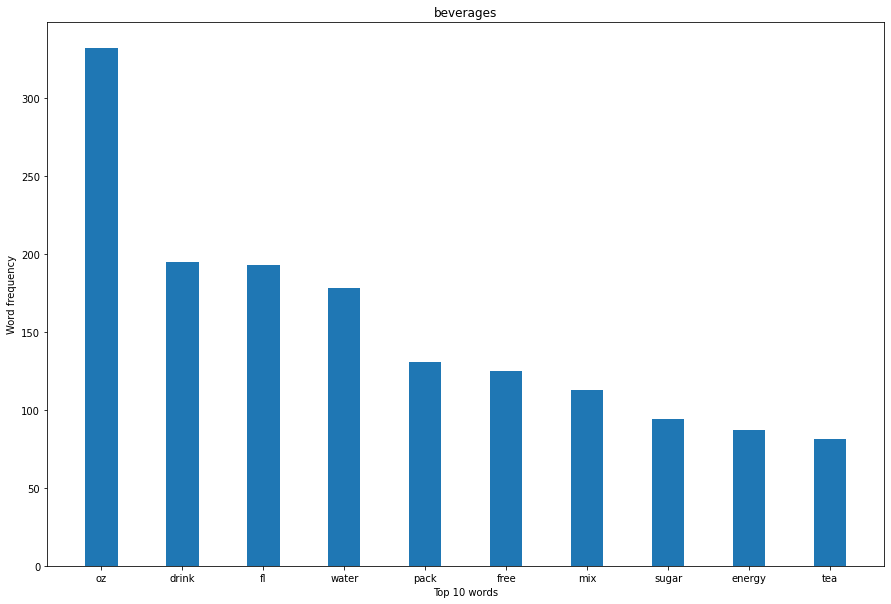

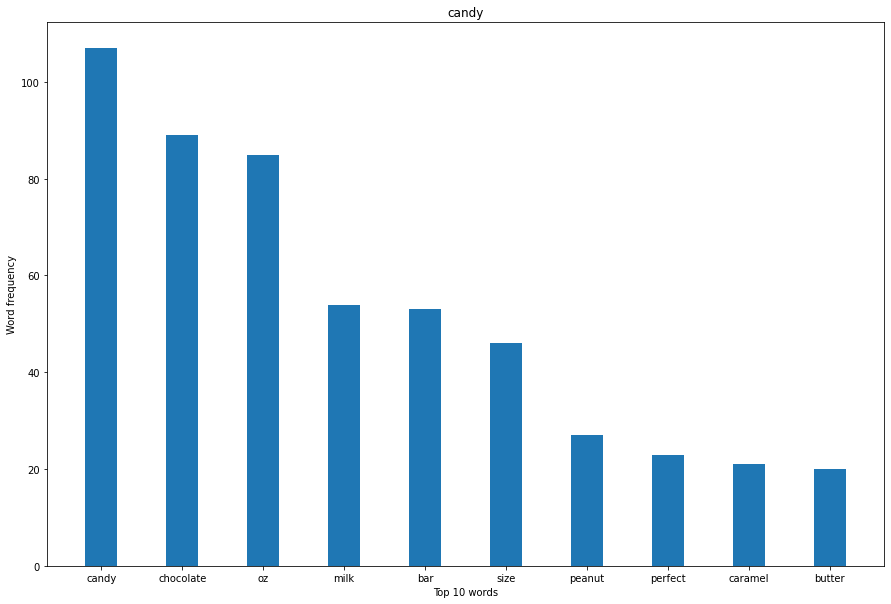

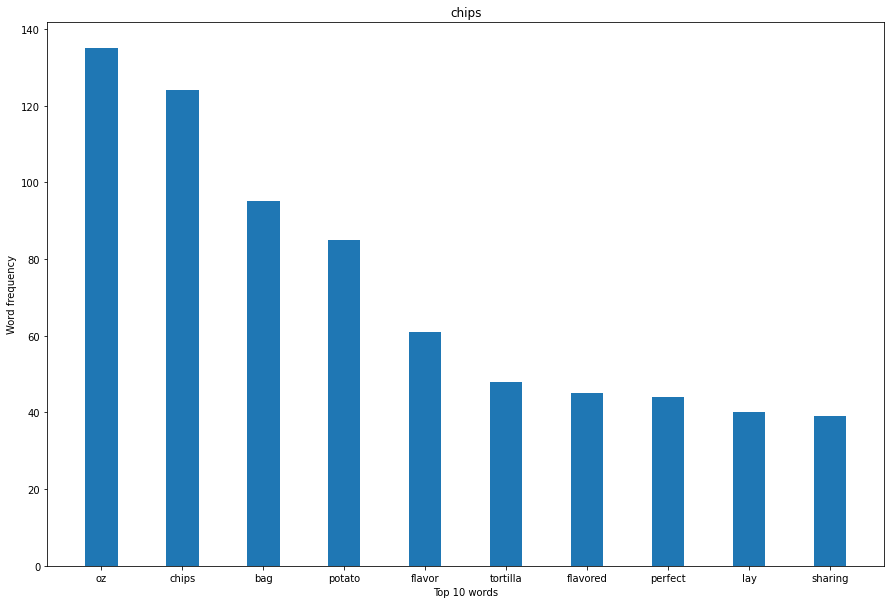

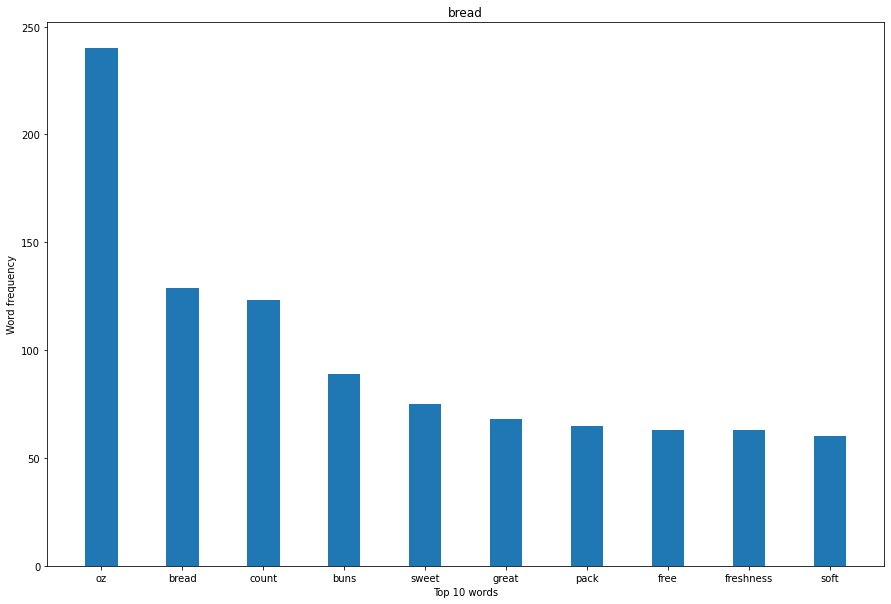

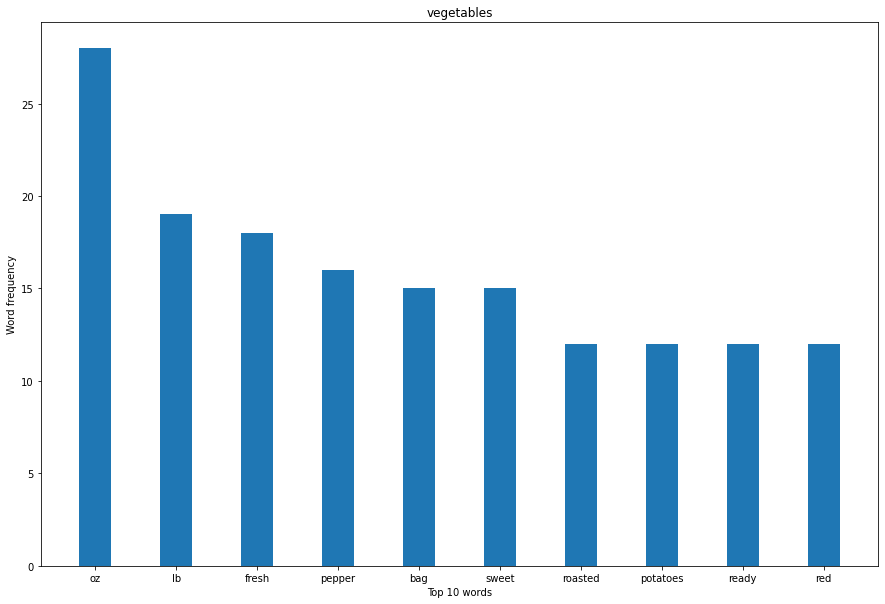

In [ ]:
for item in full_words_files_list:
  category = item.split("_")[-1].replace(".txt","")
  f = open(item, 'r')
  lines = f.readlines()
  doc_tokenized = [simple_preprocess(line) for line in lines] # gives a list of multiple sublists. Each sublist represents a line.
  
  words = [] # a list of words that collapses the multiple sublists in the doc_tokenized.
  for i in range(len(doc_tokenized)):
    words+=doc_tokenized[i]
  counts = Counter(words) # use Counter() to count word frequency. It gives dictionaries.
  top_10 = counts.most_common(10) # gives the top 10 high frequency words.

  word = []
  frequency = []
  for x,y in top_10:
    word.append(x)
    frequency.append(y)  
  fig = plt.figure(figsize = (15, 10))    
  # creating the bar plot
  plt.bar(word, frequency,width = 0.4)  
  plt.xlabel("Top 10 words")
  plt.ylabel("Word frequency")
  plt.title(category)
  plt.show()



#### Q.7

Plot the graphs (5 in total) representing the 20 most relevant keysowrds based on the TF-IDF in each category. For instance, th egraph for the `candy` category may look like the following.

![](https://www.dropbox.com/s/l8gvex0s1sgyr2l/candy_top20.png?dl=1)



In [ ]:
### Write you code here.
def word_tfidf(corpus):
  vectorizer = TfidfVectorizer(stop_words = "english")
  tfs = vectorizer.fit_transform(corpus)
  feature_names = vectorizer.get_feature_names_out()
  n = feature_names.shape # get the shape of the feature_names array
  tfs_array = np.array(tfs.sum(0))  # tfs.sum(0) is how we get the actual numerical representations of the tfs_array
  tfs_array.shape = n # set the shape of tfs_array the same as the feature_names array for the convenience of later computation.
  word_tfs = list(zip(feature_names, tfs_array)) # convert the zip object to a list for the convenience of further computation.
  word_tfs_arry = np.array(word_tfs) # convert the list to numpy array for the convenience of sorting.
  n = 20
  result = word_tfs_arry [word_tfs_arry [:, 1].argsort()[::-1][:n]] #.argsort(): sort a numpy array. [::-1]: sort reversely. [:n]: the first n.  
  
  word = [] # create a word list for the x_axis of a plot later
  tf_idf = [] # create a word list for the y_axis of a plot later
  for k,v in result:
    word.append(k)
    tf_idf.append(v)
  tf_idf_round = [round(float(num), 2) for num in tf_idf] # round the tf_idf to 2 decimals.
  
  fig = plt.figure(figsize = (20, 15))    
  # creating the bar plot
  plt.bar(word, tf_idf_round,width = 0.4)  
  plt.xlabel("Top 20 words")
  plt.ylabel("tf-idf score")
  plt.title(file)
  plt.show()

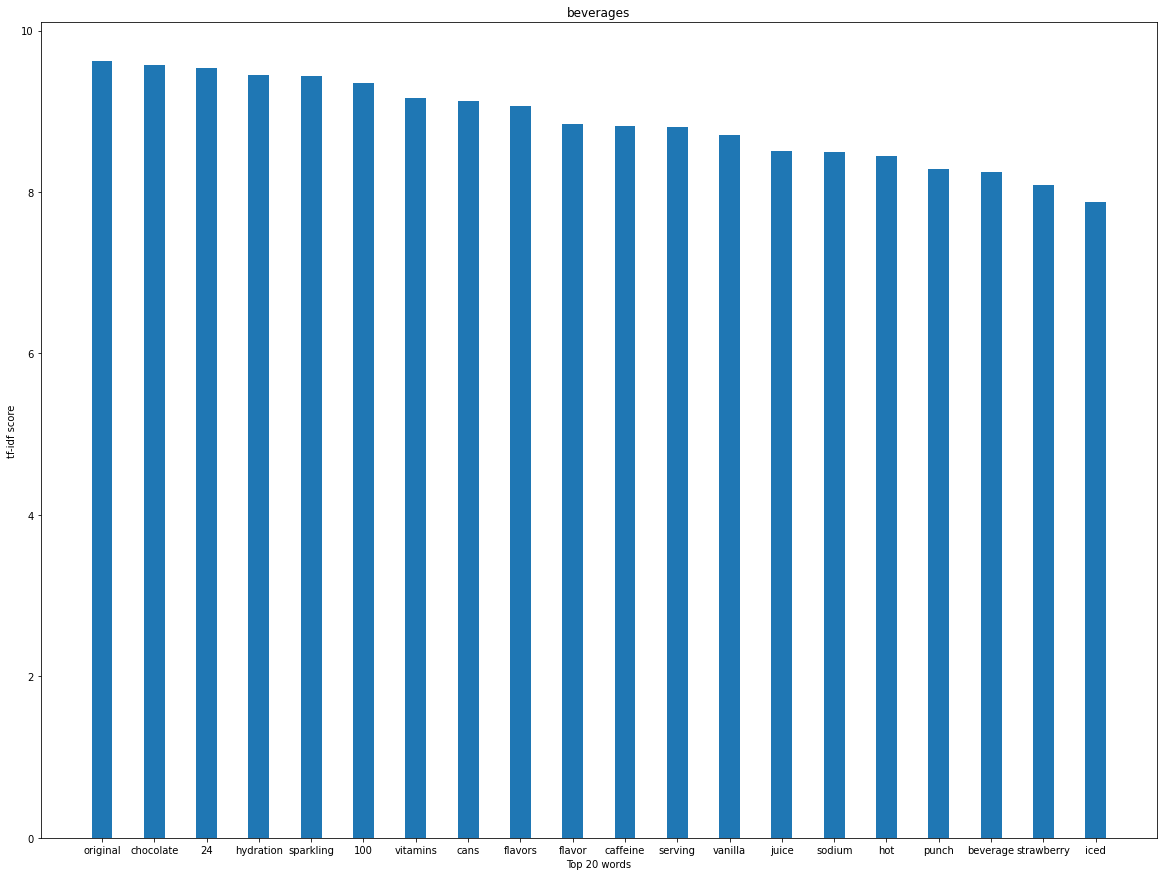

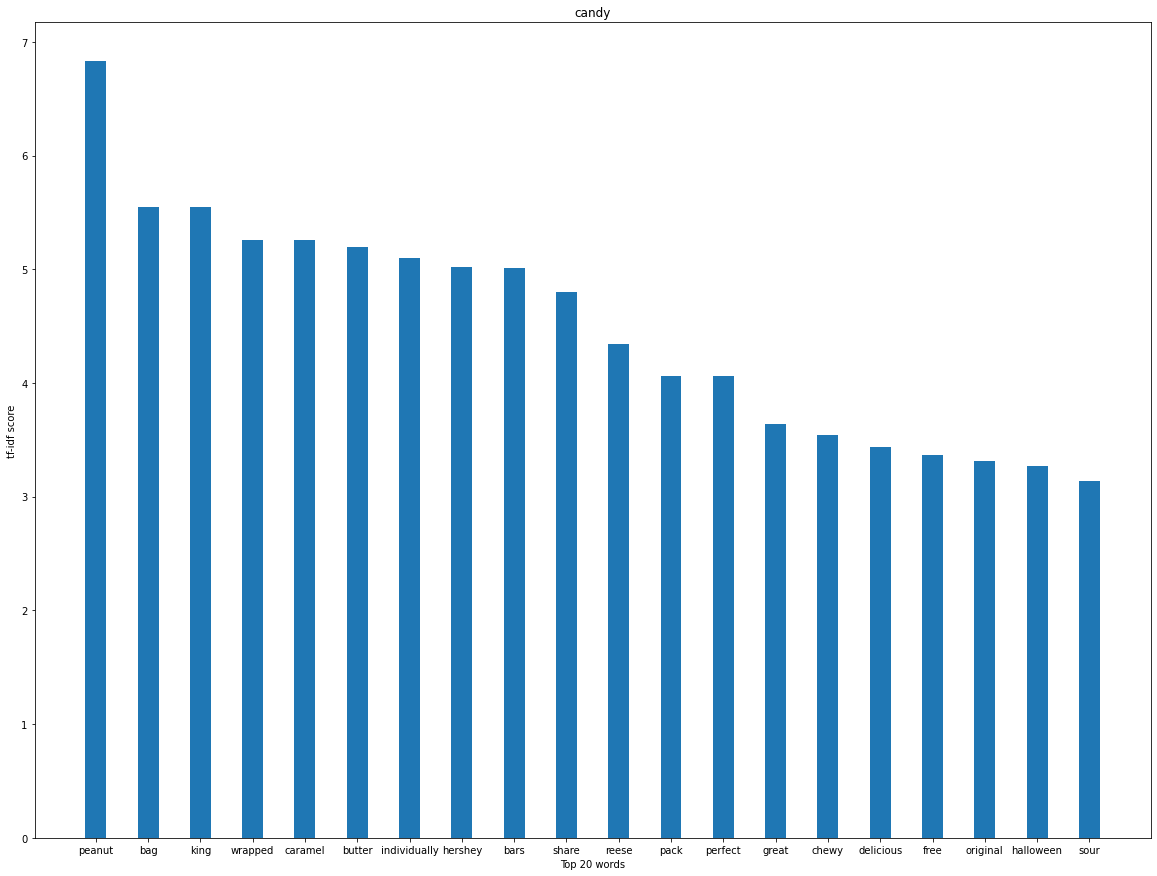

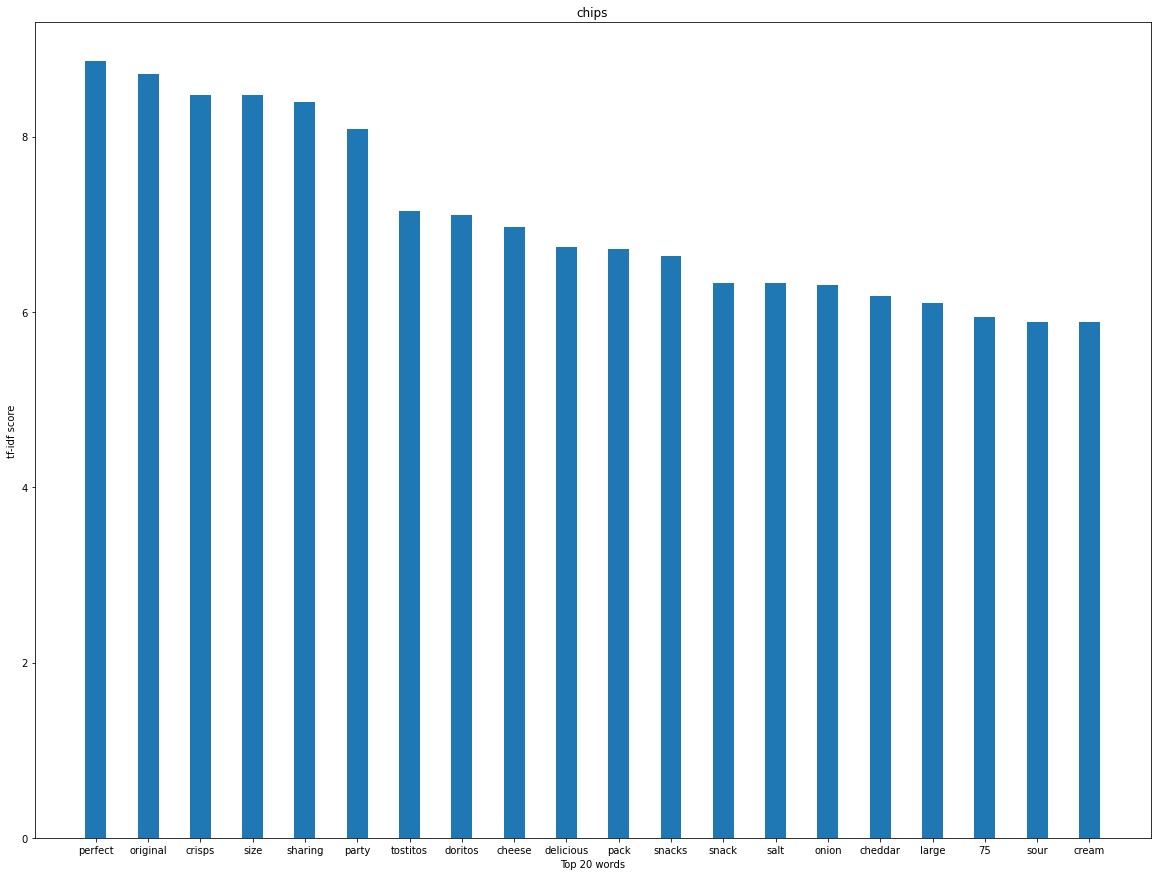

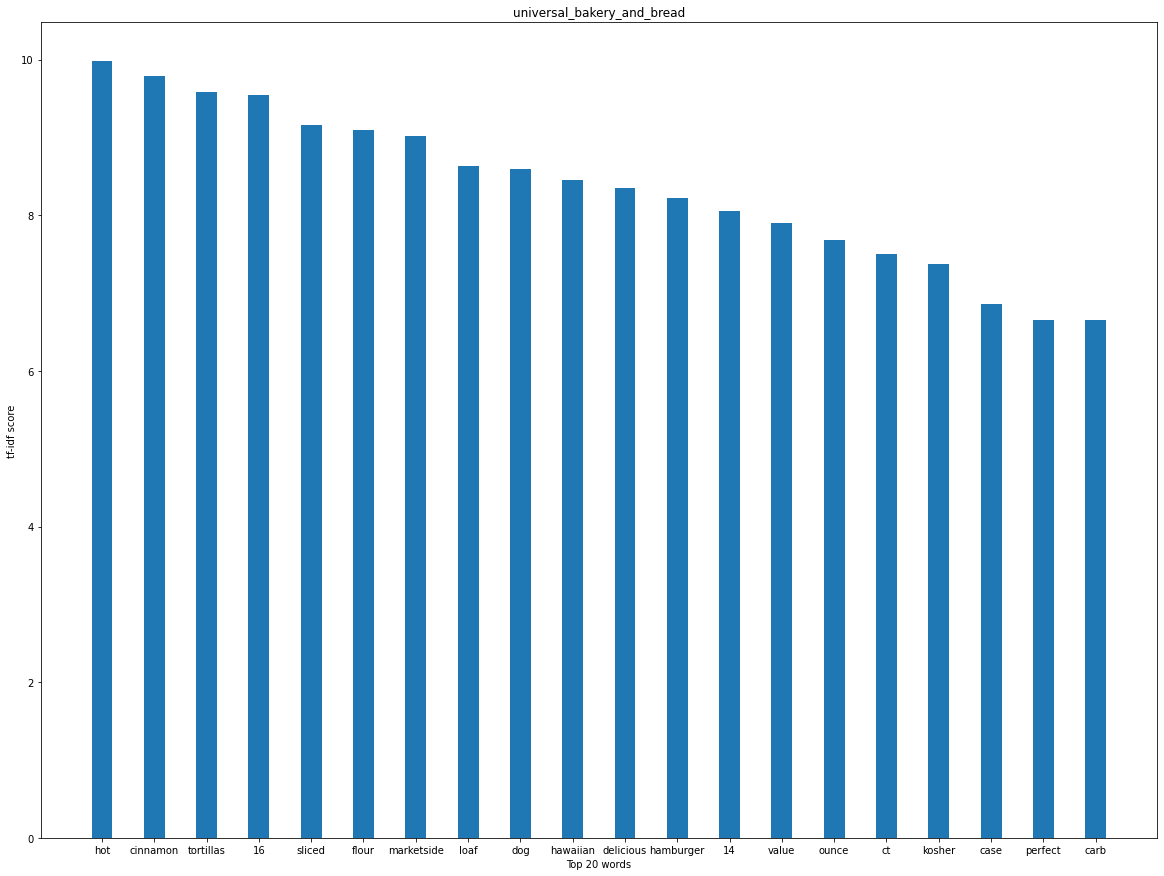

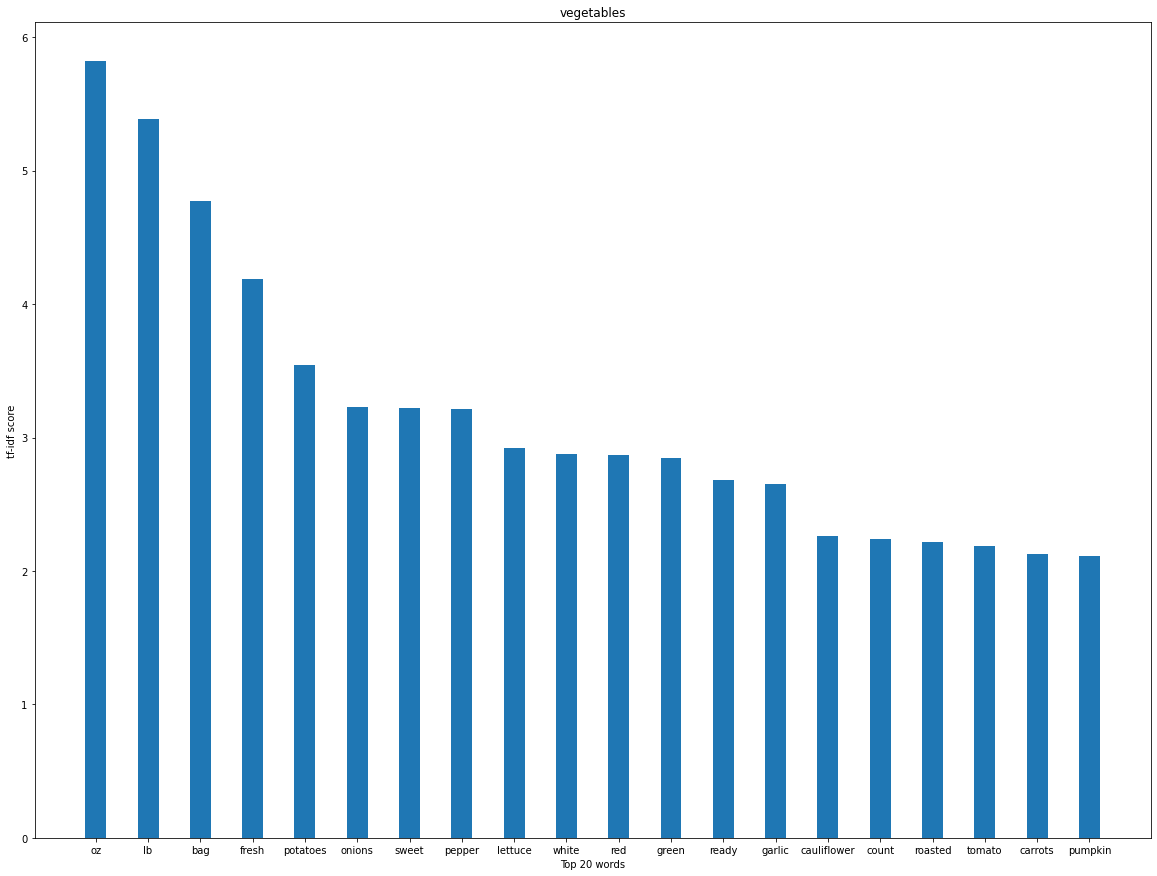

In [ ]:
files = ['beverages', 'candy','chips','universal_bakery_and_bread','vegetables']
for file in files:
  file_path = "/content/drive/MyDrive/Colab Notebooks/assignment-2-KTW2022-main/data/"+"clean_text_"+file+".txt"
  f = open(file_path, 'r')
  corpus = f.readlines()
  word_tfidf(corpus)


### K-nearest Neighbor classification

The following section will help you sort product names into one of five categories using a naive approach. In essence, the approach assigns a product name to the category with which it shares the most words, weighted by the TF-IDF.

Here, we will be using the queries in the file `test_names.tsv`(tab-delimited format). This file contains the true labels, which we will use to measure our approach's accuracy.



#### Q.8

Write a function that takes a name and computes the sum of TF-IDF values for all its words in each of the categories. For exmaple, if a product name is "Small World Chips", and the TF-IDF for the words ["Small", "World", "Chips"] are [0.1, 0.002, 0.9] and [0.8, .0002, 0.002] for the chips and candy categories, the the function would return a dictionary with the follwing: `{"candy": 0.8022, "chips": 1.002}`. Call you function `sum_tf_ids`.


Note that for each product query, you simply need to split the sequence into words and take care in removing apostrophes and punctuation and converting the words into an appropriate case. You do not need to remove stop words and words that are not relevant as those will not match against words in the categories. 

In [ ]:
### Write you code here. 
def tf_idf_corpus(corpus):
    vectorizer = TfidfVectorizer(stop_words = "english")
    tfs = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names_out()
    n = feature_names.shape # get the shape of the feature_names array
    tfs_array = np.array(tfs.sum(0))  # tfs.sum(0) is how we get the actual numerical representations of the tfs_array
    tfs_array.shape = n # set the shape of tfs_array the same as the feature_names array for the convenience of later computation.
    word_tfs = list(zip(feature_names, tfs_array)) # convert the zip object to a list for the convenience of further computation. format: (word, its tfidf)
    return  word_tfs # data type is "list"
  

In [ ]:
files = ['beverages', 'candy','chips','universal_bakery_and_bread','vegetables']
tf_idf_list = [] # a list of arrays (5 categories)
for file in files:
    file_path = "/content/drive/MyDrive/Colab Notebooks/assignment-2-KTW2022-main/data/"+"clean_text_"+file+".txt"
    f = open(file_path, 'r')
    corpus = f.readlines()
    result = dict(tf_idf_corpus(corpus)) # tf_idf_corpus(corpus) is an array of word_tfs for each category. dict() converts it to a dictioanry. Key: word. Value: tfidf score.
    tf_idf_list.append(result) 

In [ ]:
def sum_tf_ids(name): # "name" is each product name in the product_names from product_name(filepath).
    name_list = []
    dictionary = {}
    for word in name.split(" "): # e.g. name = "small world chips"
        word = word.lower().translate(str.maketrans('', '', string.punctuation))
        name_list.append(word) # e.g. name_list = ["small", "world", "chips"]
  
    sum_score = 0
    for j in range(len(tf_idf_list)):
        for word in name_list:
            if tf_idf_list[j].get(word) is not None:
                score = float(tf_idf_list[j].get(word)) # for the ditionary of tf_idf_list[j], get the tfidf score of the word.
                sum_score+=score  
            else:
                score = 0
                sum_score+=score 
                
        if j == 0:
            dictionary['beverages']=sum_score
        if j == 1:
            dictionary['candy']=sum_score
        if j == 2:
            dictionary['chips']=sum_score
        if j == 3:
            dictionary['universal bakery and bread']=sum_score
        if j == 4:
            dictionary['vegetables']=sum_score
        sum_score = 0
    return dictionary

#### Q.9

You can test your function by using the following sentence. The sum of TF-IDF values should be higher for candy and beverages than for vegetables.

```
"Baby Bottle Pop Original Candy Lollipops with Dipping Powder, Assorted Flavors, 1.1 oz"
```

In [ ]:
### Write your code here
name = "Baby Bottle Pop Original Candy Lollipops with Dipping Powder, Assorted Flavors, 1.1 oz"
sum_tf_ids(name)

{'beverages': 87.89853137536275,
 'candy': 37.463110798971854,
 'chips': 38.57794071246923,
 'universal bakery and bread': 49.529826219110234,
 'vegetables': 7.523470704711212}

#### Q.10

Repeat the process above for each of the products in the test folder. For each product name (line in the file `test_names.tsv`), use the label associated with largest `TF-IDF` sum value returned by `sum_tf_ids` function as an indicator for predicted class. How many correction predictions did this naive approach make?

In [ ]:
### Write you code here
file_path = "/content/drive/MyDrive/Colab Notebooks/assignment-2-KTW2022-main/data/tests/test_names.tsv"
f = open(file_path, 'r')
score = 0
label_list = []
for line in f.readlines():
  name = line.split("\t")[0] # product name
  label = line.split("\t")[1].replace("\n","") # category label
  label_list.append(label)
  #max_sum_tfs = max(sum_tf_ids(name).values()) # gives the largest TF-IDF sum value 
  max_key = max(sum_tf_ids(name), key = sum_tf_ids(name).get) # gives the key of the largest TF-IDF sum value 
  if max_key == label:
    score += 1
  else:
    score += 0 
correct_label = round((score / len(label_list)),2)

print(correct_label)

0.59


#### Q.11

Did the model properly classify the following product title?
`Jumbo Push Pop, Assorted Flavor Spring Lollipop, 1.06oz candy`

Explain why it did or didn't.


In [ ]:
# Write your answer here
name = "Jumbo Push Pop, Assorted Flavor Spring Lollipop, 1.06oz candy"
max_key = max(sum_tf_ids(name), key = sum_tf_ids(name).get)
max_key

'candy'

In [ ]:
Answer: The model could properly classify the produce name above. It classified it as "candy". 

### Part 2: Using Sentence Embeddings

Here, we will generate embeddings for the product names and descriptions using Sentence Transformers which we will use to find products in the training data with the most similar name or description to some input product name. If you haven't already done so, install the Sentence Transformers library (see the first cell of this notebook). Run the following line to instantiate the `SentenceTransformer` using Microsoft’s `MPNet` transformer. 

In [8]:
model = SentenceTransformer('all-mpnet-base-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

#### Q.12

Use the model above to compute the embedding for the following product description:

```   

'Kinder Bueno, Milk Chocolate and Hazelnut Cream, 4 Individually Wrapped Chocolate Bars, .75 oz each'

```

- What is the embedding dimension?


In [9]:
# ### Write your code here
sentence = ["Kinder Bueno, Milk Chocolate and Hazelnut Cream, 4 Individually Wrapped Chocolate Bars, .75 oz each"]
embeddings = model.encode(sentence)
embeddings.shape

(1, 768)

#### Q.13

Embed the product names in the training data using the sentence transformer model you created above. The results should be saved as a file with the extension `category.embed`, (e.g., `candy.embed`).

In [ ]:
### Write you code here
def product_name(filepath):
  f = open(filepath, "r+b")
  f_list = f.readlines()
  f_dict = []
  for i in f_list: 
    f_dict.append(json.loads(i))
  product_names = []
  for i in f_dict:
    name = i['name']
    product_names.append(name)
  return product_names  

In [ ]:
def embedding(result):
  embeddings_list = []
  for sentence in result:
    embeddings = model.encode(sentence)
    embeddings_list.append(embeddings)
  file_path = "/content/drive/MyDrive/Colab Notebooks/assignment-2-KTW2022-main/data/" + file + ".embed.txt"
  # open file in write mode
  with open(file_path, 'w') as fp:
    for item in embeddings_list:
      # write each item on a new line
      fp.write("%s\n" % item)
    print('Done')

In [ ]:
files = ['beverages', 'candy','chips','universal_bakery_and_bread','vegetables']
for file in files: 
  filepath = "/content/"+ project_folder + file + ".jsonl"
  result = product_name(filepath) 
  embedding(result)

Done
Done
Done
Done
Done


#### Q.14

Write a function that takes in embedding a sentence as input and searches each of the embedding files to retrieve the most similar items and the categories to which it belongs. Call your function `knn_manual_search`. Use any distance (or similarity) metric you deem appropriate but justify it in the cell below.

In [ ]:
### Which distnace metric will you be using and why?
I chose to use cosine similarity. It is because if two similar vectors are far apart by the Euclidean distance, 
especially due to the size of the two documents, the angles between them can still be small, not affected by the magnitude of the vectors. 
In other words, from cosine similiarity, the two vectors can still be indetified as close to each other. 


In [ ]:
### Write your code here
# ref: https://www.sbert.net/examples/applications/semantic-search/README.html
def knn_manual_search(sentence_embedding): # takes in one sentence_embedding
    embedding1 = sentence_embedding
    dictionary ={} 
    for j in range(len(embeddings_list)):  # embeddings_list[j] refers to each category' embeddings.
        #Compute cosine-similarities
        cosine_scores = util.cos_sim(embedding1, embeddings_list[j])[0]
        top_k = min(1, len( embeddings_list[j])) # find the closest sentence in the embeddings_list[j] for the product name from the test file.
        max_cosine = torch.topk(cosine_scores, k=top_k)
            
        if j == 0:
            dictionary['beverages'] = max_cosine
        if j == 1:
            dictionary['candy'] = max_cosine
        if j == 2:
            dictionary['chips'] = max_cosine
        if j == 3:
            dictionary['universal bakery and bread'] = max_cosine
        if j == 4:
            dictionary['vegetables'] = max_cosine
       
    max_key = max(dictionary, key = dictionary.get) # gives the key of the largest cosine similarity value.
    return max_key

#### Q.15

Using the strategy consisting of assigning to a product the category of its best hit, use your implementation of the function `knn_manual_search` to assign categories to each of the product descriptions in the test file.



In [ ]:
### Write you code here
def product_name(filepath):
    f = open(filepath, "r+b")
    f_list = f.readlines()
    f_dict = []
    for i in f_list: 
        f_dict.append(json.loads(i))
        product_names = []
    for i in f_dict:
        name = i['name']
        product_names.append(name)
    return product_names  

In [ ]:
files = ['beverages', 'candy','chips','universal_bakery_and_bread','vegetables']
embeddings_list = []
for file in files: 
    filepath = "/content/drive/MyDrive/Colab Notebooks/assignment-2-KTW2022-main/data/train/" + file + ".jsonl"
    corpus = product_name(filepath) 
    corpus_embeddings = model.encode(corpus, convert_to_tensor=True)
    embeddings_list.append(corpus_embeddings)

In [ ]:
### write your code here
file_path = "/content/drive/MyDrive/Colab Notebooks/assignment-2-KTW2022-main/data/tests/test_names.tsv"
f = open(file_path, 'r')
name_list = []
label_list = []
for line in f.readlines():
    name = line.split("\t")[0] # product name
    name_list.append(name)
    label = line.split("\t")[1].replace("\n","")
    label_list.append(label)

In [ ]:
def embedding(sentence):
    embeddings = model.encode(sentence)
    return embeddings

In [ ]:
name_encoding_list = []
name_label_dict = {}
score = 0
for name in name_list:
    name_encoding_list.append(embedding(name)) # embedding(name): call the function of embedding() to encode each product name in the test file.    
for i in range(len(name_encoding_list)):
    category = knn_manual_search(name_encoding_list[i]) # find the max_key (i.e. category) of each product name in the test file.
    if category == label_list[i]:
        score += 1
    else:
        score +=0
correct_label = score / len(label_list)
correct_label 
    #name_label_dict[name_list[i]] = category
#name_label_dict

1.0

#### Q.16

Use Facebook's [FAISS](https://github.com/facebookresearch/faiss) library to classify product names to categories based on a slightly different strategy. Here, instead of assigning a product name to the category of its best hit, we will assign it to the category representing the majority of the 5 best hits. As an exception to the guideline we set earlier, you can load all the embeddings in RAM and pass thm to an L2 FLAT index in FAISS. call you function `knn_FAISS`?





In [ ]:
### Write your code here
def product_name(filepath):
    f = open(filepath, "r+b")
    f_list = f.readlines()
    f_dict = []
    for i in f_list: 
        f_dict.append(json.loads(i))
        product_names = []
    for i in f_dict:
        name = i['name']
        product_names.append(name)
    return product_names  

In [ ]:
#corpus_embeddings.shape
#embeddings_array = np.array(embeddings_list, dtype=object)
#embeddings_array.shape
beverages_array = embeddings_list[0]
candy_array = embeddings_list[1]
chips_array = embeddings_list[2]
bakery_and_bread_array = embeddings_list[3]
vegetables_array = embeddings_list[4]
embeddings_array = np.vstack([beverages_array,candy_array,chips_array,bakery_and_bread_array,vegetables_array])
#embeddings_array.shape

In [ ]:
def knn_FAISS(sentences): # sentences: a list of name products in the test file.
  model = SentenceTransformer('all-mpnet-base-v2')
  embeddings = model.encode(sentences) # a list of sentence encodings for all the name produces in the test file.
  beverages_length = len(embeddings_list[0])
  candy_length = len(embeddings_list[1])
  chips_length = len(embeddings_list[2])
  bakery_and_bread = len(embeddings_list[3])
  vegetables = len(embeddings_list[4])
  dimension = 768 # In the SentenceTransformer('all-mpnet-base-v2'), there are 768 features used for embedding. 
  index = faiss.IndexFlatL2(dimension)
  index.add(embeddings_array) # add the embeddings _array, which is the search database, to the index training.
  k = 5  # return 5 nearest neighbours
  distances, indices = index.search(embeddings, k) # search on the embeddings_array to find the 5 nearest neighbors for the product names in the test file.
  label_classified = []
  for index in indices: # indices is an array. The # of rows is the number of the product names in the test files. The # of columns is the number of k. 
    category_list = []
    for num in index:
      if num < beverages_length: # 0 - 408
        category_list.append('beverages')
      elif beverages_length <= num < (beverages_length + candy_length): # 409 <= num < 500
        category_list.append('candy')
      elif (beverages_length + candy_length) <= num < (beverages_length + candy_length + chips_length): # 500 <= num < 630
        category_list.append('chips')
      elif (beverages_length + candy_length + chips_length) <= num < (beverages_length + candy_length + chips_length + bakery_and_bread ): # 630 <= num < 958
        category_list.append('universal bakery and bread')
      else:
        category_list.append('vegetables')
    count = Counter(category_list)
    label_classified.append(count.most_common(1))
  return label_classified

In [ ]:
file_path = "/content/drive/MyDrive/Colab Notebooks/assignment-2-KTW2022-main/data/tests/test_names.tsv"
f = open(file_path, 'r')
name_list = []
label_list = []
for line in f.readlines():
    name = line.split("\t")[0] # product name
    name_list.append(name)
    label = line.split("\t")[1].replace("\n","")
    label_list.append(label)

In [ ]:
result = knn_FAISS(name_list)
result

[[('vegetables', 5)],
 [('vegetables', 5)],
 [('universal bakery and bread', 5)],
 [('chips', 5)],
 [('chips', 5)],
 [('universal bakery and bread', 5)],
 [('vegetables', 5)],
 [('vegetables', 5)],
 [('candy', 5)],
 [('chips', 5)],
 [('beverages', 4)],
 [('chips', 5)],
 [('chips', 5)],
 [('beverages', 5)],
 [('beverages', 5)],
 [('vegetables', 5)],
 [('vegetables', 5)],
 [('vegetables', 5)],
 [('candy', 5)],
 [('vegetables', 5)],
 [('vegetables', 5)],
 [('chips', 5)],
 [('chips', 5)],
 [('universal bakery and bread', 5)],
 [('candy', 3)],
 [('universal bakery and bread', 5)],
 [('beverages', 5)],
 [('candy', 4)],
 [('beverages', 5)],
 [('beverages', 5)],
 [('universal bakery and bread', 5)],
 [('chips', 5)],
 [('universal bakery and bread', 5)],
 [('beverages', 5)],
 [('chips', 5)],
 [('universal bakery and bread', 5)],
 [('candy', 3)],
 [('candy', 5)],
 [('beverages', 5)],
 [('candy', 5)],
 [('candy', 3)],
 [('candy', 5)],
 [('universal bakery and bread', 5)],
 [('universal bakery and

In [ ]:
score = 0
for i in range(len(label_list)):
  if label_list[i] == result[i][0][0]:
    score += 1
  else:
    score += 0
correct_label = score / len(label_list)
correct_label 

1.0

#### Q.17

Do the results produced by knn_maanual_search differ from those produced by knn_FAISS? If so, provide a single use case explaining why the results were different between the two approaches.





In [ ]:
### Provide your answer here
The results produced by knn_manual_search are the same as those produced by knn_FAISS. The probabilities of correct labeling in the two methods are both 1.0.


#### Q.18

Use the `facebook/bart-large-mnli` in conjunction with HuggingFace’s transformers library to build a zero-shot classification model and assign each test product name to one of the 5 possible categories.
See the following for more details 
https://huggingface.co/facebook/bart-large-mnli



In [ ]:
### Write your code here
file_path = "/content/drive/MyDrive/Colab Notebooks/assignment-2-KTW2022-main/data/tests/test_names.tsv"
f = open(file_path, 'r')
name_list = []
label_list = []
for line in f.readlines():
    name = line.split("\t")[0] # product name
    name_list.append(name)
    label = line.split("\t")[1].replace("\n","")
    label_list.append(label)

In [ ]:
results = []
for name in name_list:
  sequence_to_classify = name
  candidate_labels = ['beverages', 'candy', 'chips','universal bakery and bread','vegetables']
  result = classifier(sequence_to_classify, candidate_labels)
  results.append(result)

In [ ]:
label_predicted = []
for result in results:
  first_label = result['labels'][0]
  label_predicted.append(first_label)
label_predicted

['vegetables',
 'beverages',
 'candy',
 'chips',
 'chips',
 'beverages',
 'vegetables',
 'vegetables',
 'candy',
 'chips',
 'beverages',
 'chips',
 'chips',
 'beverages',
 'beverages',
 'beverages',
 'vegetables',
 'beverages',
 'candy',
 'beverages',
 'beverages',
 'chips',
 'candy',
 'universal bakery and bread',
 'candy',
 'beverages',
 'beverages',
 'candy',
 'beverages',
 'beverages',
 'candy',
 'beverages',
 'candy',
 'beverages',
 'chips',
 'beverages',
 'candy',
 'candy',
 'beverages',
 'candy',
 'candy',
 'candy',
 'universal bakery and bread',
 'universal bakery and bread',
 'universal bakery and bread',
 'chips',
 'beverages',
 'beverages',
 'candy']

In [ ]:
score = 0
for i in range(len(label_list)):
  if label_list[i] == label_predicted[i]:
    score += 1
  else:
    score += 0
correct_label = score / len(label_list)
round(correct_label,2)

0.71

#### Q.19

Which of the three models above (TF-IDF, `knn_manual_search`,  `knn_FAISS`, zero-shot classification) produced the most accurate results? Why do you believe that is the case? In this case, there are no right or wrong answers, and, therefore, any reasonable justification will be considered as correct.


In [ ]:
### Write your answer here
According to the calculations above, the accuracy rates of the four approaches are as follows:
TF-IDF: 0.59
knn_manual_search: 1.0
knn_FAISS = 1.0
zero-shot classification = 0.71
Therefore, both knn_manual_search and knn_FAISS produced the most accurate results. 

The knn_FAISS approach uses IndexFlatL2 that uses Euclidean distance to calculate the distance between sentences.
It is said to be a brute-force apprach. The result is considered very accurate.  
The knn_manual_search approach uses cosine similarity to search for the nearest vector. 
The good thing about it is that the search will not be affected by the distance of the two vectors.
As long as the two vectors are similar, the angle between them is small and the corresponding cosine similarity score will be high.
